# Playground K-Nearest Neighbors

### Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt

### Functions and Classes

In [0]:
def train_test_split(*arrays, test_ratio=0.1, random_state=42):
    """Split the data onto train set and test set. The function shuffle the data 
    before splitting it

    Parameters:
    ----------

    *arrays: array-like
        Sequence of indexables with same length / shape[0]

    test_ratio : float, between 0 and 1
        Percentage of test set 

    random_state : integer
        Random state seed

    Returns:
    -------

    splitting : list, length=2 * len(arrays)
        List containing train-test split of inputs.
    
    """

    np.random.seed(random_state)
    index = np.random.permutation(np.arange(len(arrays[0])))
    test_size = int(len(arrays[0])*test_ratio)

    def wrapper():
        for element in arrays:
            test_index = index[:test_size]
            train_index = index[test_size:]
            test = element[test_index]
            train = element[train_index]
            yield train
            yield test

    return tuple(wrapper())

class MinMaxScaler(object):
    """ Scaling the data to between 0 and 1 """

    def __init__(self):
        pass
    
    def fit(self, X):
        self.min_ = X.min(axis=0)
        self.max_ = X.max(axis=0)

        return self

    def transform(self, X):
        diff_X = X - self.min_
        diff_minmax = self.max_ - self.min_

        return diff_X / diff_minmax
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


class StandardScaler(object):
    """ Standardize the data """
    
    def __init__(self):
        pass
    
    def fit(self, X):
        self.mean_ = X.mean(axis=0)
        self.stddev_ = X.std(axis=0)

        return self

    def transform(self, X):
        diff_mean = X - self.mean_

        return diff_mean / self.stddev_
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

def accuracy_score(predictions, labels):

    """Calculate the accuracy score between predictions and labels. \
    The percentage of correct predictions.

    Parameters:
    ----------

    predictions : array-like
    The predictions of an estimator

    labels : array-like
    The true labels of data

    Raise:
    -----

    ValueError: raise value error when the length of predictions and labels are not the same

    """


    if len(predictions) == len(labels):
        return np.sum(np.equal(predictions, labels)) / len(predictions)
    else:
        raise ValueError("The length of predictions and labels are not the same")


def r2_score(predictions, labels):

    """Calculate R-Squared (Coefficients of Determination) between predictions and labels.

    Parameters:
    ----------

    predictions : array-like
    The predictions of an estimator

    labels : array-like
    The true labels of data

    Raise:
    -----

    ValueError: get raised when the length of predictions and labels are not the same

    """
    
    
    predictions = predictions.ravel()
    labels = labels.ravel()
    if len(predictions) == len(labels):
        ybar = np.mean(labels)
        sres = np.sum(np.power(labels - predictions, 2))
        stot = np.sum(np.power(labels - ybar, 2))
        return 1 - (sres / stot)
    else:
        raise ValueError("The length of predictions and labels are not the same")


### Dataset

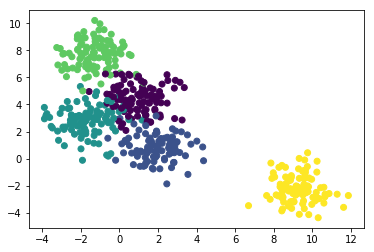

In [0]:
from sklearn.datasets import make_blobs

X_class, y_class = make_blobs(n_samples=500, centers=5, n_features=2, random_state=0)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class)

plt.scatter(X_class[:, 0], X_class[:, 1], c=y_class);

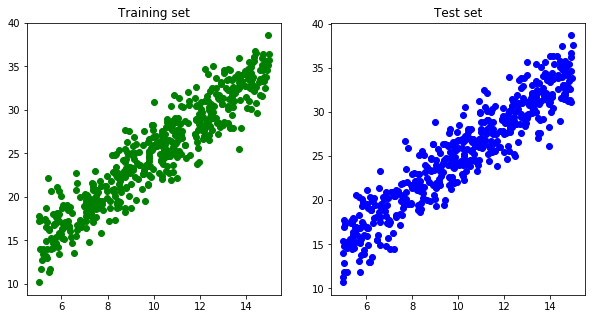

In [0]:
X_train_r = np.random.uniform(0, 10, size=(500, 1)) + 5
X_test_r = np.random.uniform(0, 10, size=(500, 1)) + 5
bias = np.random.normal(0, 2, size=(500, 1))
y_train_r = 2 * X_train_r + 5 + bias
y_test_r = 2 * X_test_r + 5 + bias

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].scatter(X_train_r, y_train_r, c='g')
axes[0].set_title("Training set")
axes[1].scatter(X_test_r, y_test_r, c='b')
axes[1].set_title("Test set");

### Model to Compare

In [0]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

knn_c = KNeighborsClassifier().fit(X_train_c, y_train_c)
knn_r = KNeighborsRegressor().fit(X_train_r, y_train_r)
print("KNeighborsClassifier score: ", knn_c.score(X_test_c, y_test_c))
print("KNeighborsRegressor score: ", knn_r.score(X_test_r, y_test_r))

KNeighborsClassifier score:  0.9
KNeighborsRegressor score:  0.8596785086831998


---

## Neighbors(base)

In [0]:
class KNNBase(object):

    def __init__(self, k_neighbors, scaler, order):
        self.k_neighbors = k_neighbors
        self.scaler = scaler
        self.order = order

    def fit(self, X, y):
        if self.scaler == None:
            self._X = X
        elif self.scaler == 'minmax':
            self._scaler = MinMaxScaler()
            self._X = self._scaler.fit_transform(X)
        elif self.scaler == 'standard':
            self._scaler = StandardScaler()
            self._X = self._scaler.fit_transform(X)
        else:
            raise ValueError("Unknown scaler")

        self._y = y
        return self
    
    def predict():
        pass

    def score():
        pass

---

## KNNClassifier

In [0]:
class KNNClassifier(KNNBase):

    def __init__(self, k_neighbors=5, scaler=None, order=2):
        super().__init__(k_neighbors=k_neighbors, 
                         scaler=scaler,
                         order=order)
        
    def _vote(self, arg_sorted, y_fit):
        result = np.argmax(np.bincount(y_fit[arg_sorted]).astype('int'))
        proba = np.bincount(y_fit[arg_sorted], minlength=len(np.unique(y_fit))) / len(np.unique(y_fit))
        return result, proba
        
    def predict(self, X):
        if self.scaler == None:
            X_pred = X
        else:
            X_pred = self._scaler.transform(X)
        X_fit = self._X
        y_fit = self._y

        percentage = 0
        predictions = np.zeros(X_pred.shape[0], dtype='int')
        predict_proba = np.zeros(shape=(X_pred.shape[0], np.unique(y_fit).shape[0]))
        for i in range(predictions.shape[0]):
            distance = np.zeros(X_fit.shape[0])
            for j in range(distance.shape[0]):
                distance[j] = np.linalg.norm(X_pred[i] - X_fit[j], self.order)

            arg_sorted = np.argsort(distance)[:self.k_neighbors]
            predictions[i], predict_proba[i] = self._vote(arg_sorted, y_fit)
            if i % (predictions.shape[0]/100) == 0:
                print("\rProcess {}%".format(percentage), end='')
                percentage += 1
        print("\rProcess 100%", end='\n')

        self._predictions = predictions
        return predictions, predict_proba

    def score(self, X, y):
        try:
            predictions = self._predictions
        except Exception:
            predictions, _ = self.predict(X)
        labels = y

        return accuracy_score(predictions, labels)

In [0]:
my_knn = KNNClassifier().fit(X_train_c, y_train_c)

In [0]:
my_knn.score(X_test_c, y_test_c)

Process 100%


0.9

---

## KNNRegressor

In [0]:
class KNNRegressor(KNNBase):
    
    def __init__(self, k_neighbors=5, scaler=None, order=2, aggregate='mean'):
        self.aggregate = aggregate
        super().__init__(k_neighbors=k_neighbors, 
                         scaler=scaler,
                         order=order)

    def _aggregate(self, arg_sorted, y_fit):
        # print("Nearesst neighbors: ", y_fit[arg_sorted])
        if self.aggregate == 'mean':
            result = np.mean(y_fit[arg_sorted])
        elif self.aggregate == 'median':
            result = np.median(y_fit[arg_sorted])
        else:
            raise ValueError("Unknown aggregate")
        # print("Result: ", result)
        return result
        
    def predict(self, X):
        if self.scaler == None:
            X_pred = X
        else:
            X_pred = self._scaler.transform(X)
        X_fit = self._X
        y_fit = self._y

        percentage = 0
        predictions = np.zeros(X_pred.shape[0], dtype='float')
        for i in range(predictions.shape[0]):
            
            distance = np.zeros(X_fit.shape[0], dtype='float')
            for j in range(distance.shape[0]):
                distance[j] = np.linalg.norm(X_pred[i] - X_fit[j], self.order)

            arg_sorted = np.argsort(distance)[:self.k_neighbors]
            # print(arg_sorted)
            predictions[i] = self._aggregate(arg_sorted, y_fit)

            if i % (predictions.shape[0]/100) == 0:
                print("\rProcess {}%".format(percentage), end='')
                percentage += 1
        print("\rProcess 100%", end='\n')

        self._predictions = predictions
        return predictions
    
    def score(self, X, y):
        try:
            predictions = self._predictions
        except Exception:
            predictions, _ = self.predict(X)
        labels = y

        return r2_score(predictions, labels)

In [0]:
my_knn = KNNRegressor().fit(X_train_r, y_train_r)

Process 100%
Process 100%
Process 100%


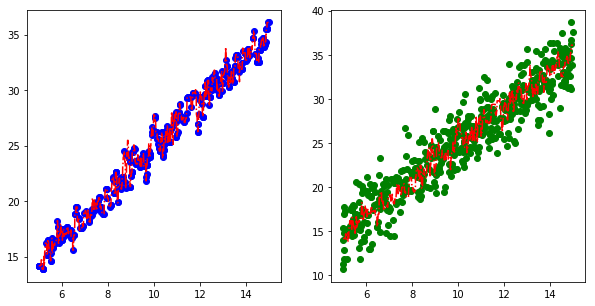

In [0]:
y_pred_r = my_knn.predict(X_test_r)
line = np.arange(5, 15, 0.01).reshape(-1, 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].scatter(X_test_r, y_pred_r, c='b')
axes[0].plot(line, my_knn.predict(line), c='r', linestyle='-.')
axes[1].scatter(X_test_r, y_test_r, c='g')
axes[1].plot(line, my_knn.predict(line), c='r', linestyle='-.');

In [0]:
from sklearn.metrics import r2_score as r2_sklearn

print(r2_sklearn(y_test_r, my_knn.predict(X_test_r)))
print(my_knn.score(X_test_r, y_test_r))

Process 100%
0.8596785086831998
0.8596785086831998
